# Chapter 3 Factor Investing and Asset Pricing

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [11, 5.5]

---

## Load Data

Source: [link](https://github.com/shokru/mlfactor.github.io/tree/master/material)

In [2]:
data_ml = pd.read_pickle('./data/data_ml.pkl').loc[pd.IndexSlice[:,'2000-01':'2018-12'], :]
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 268336 entries, (1, Period('2000-01', 'M')) to (1212, Period('2018-12', 'M'))
Data columns (total 97 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Advt_12M_Usd                    268336 non-null  float64
 1   Advt_3M_Usd                     268336 non-null  float64
 2   Advt_6M_Usd                     268336 non-null  float64
 3   Asset_Turnover                  268336 non-null  float64
 4   Bb_Yld                          268336 non-null  float64
 5   Bv                              268336 non-null  float64
 6   Capex_Ps_Cf                     268336 non-null  float64
 7   Capex_Sales                     268336 non-null  float64
 8   Cash_Div_Cf                     268336 non-null  float64
 9   Cash_Per_Share                  268336 non-null  float64
 10  Cf_Sales                        268336 non-null  float64
 11  Debtequity                  

---

## 3.2 Detecting Anomalies

### 3.2.2 Simple portfolio sorts

**Size Anomaly**

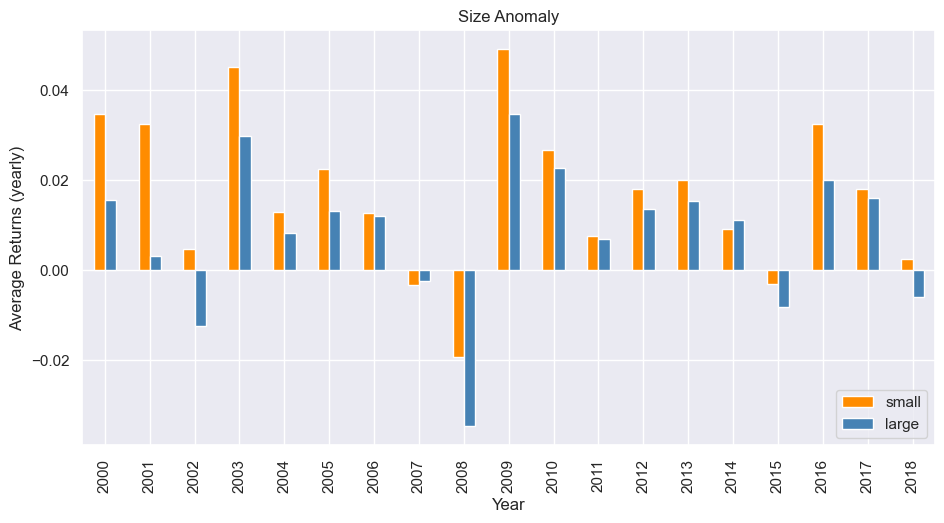

In [3]:
(
    data_ml.
    assign(large = lambda df: df.Mkt_Cap_12M_Usd > df.Mkt_Cap_12M_Usd.median()).
    assign(year = lambda df: df.index.get_level_values('month_end').year).
    groupby(by=['year', 'large'])[['R1M_Usd']].
    mean().reset_index().
    replace({'large': {True: 'large', False: 'small'}}).
    pivot(index='year', columns='large', values='R1M_Usd')[['small', 'large']].
    plot.bar(color=['darkorange', 'steelblue'])
)
plt.title('Size Anomaly')
plt.xlabel('Year')
plt.ylabel('Average Returns (yearly)')
plt.legend(loc='lower right')
pass

### 3.2.3 Factors

In [4]:
df_ff_5f_m = pd.read_pickle('./data/ff_5f_m.pkl')
df_ff_5f_m.head()

,MKT_RF,SMB,HML,RMW,CMA,RF
month_end,,,,,,
1963-07,-0.0039,-0.0047,-0.0083,0.0066,-0.0115,0.0027
1963-08,0.0507,-0.0079,0.0167,0.0040,-0.0040,0.0025
1963-09,-0.0157,-0.0048,0.0018,-0.0076,0.0024,0.0027
1963-10,0.0253,-0.0129,-0.0010,0.0275,-0.0224,0.0029
1963-11,-0.0085,-0.0084,0.0171,-0.0045,0.0222,0.0027


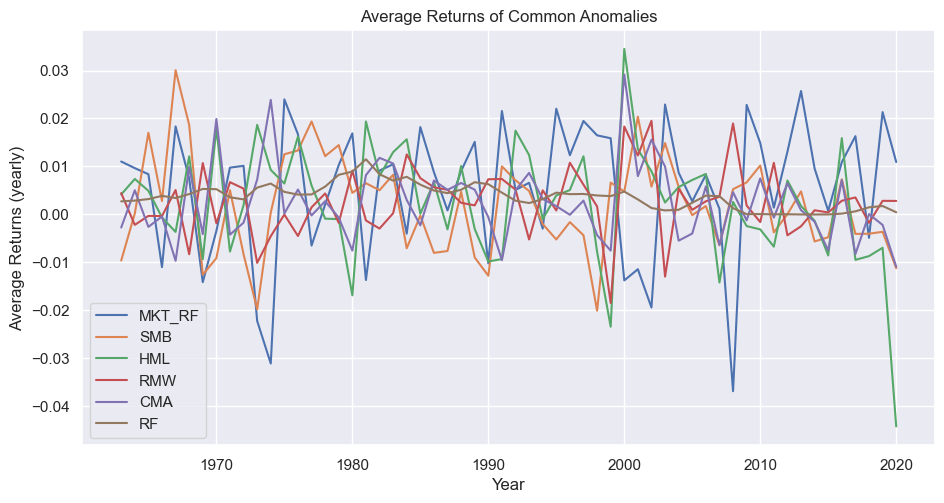

In [5]:
(
    df_ff_5f_m.
    assign(year = lambda df: df.index.year).
    groupby(by='year').mean().
    plot()
)
plt.title('Average Returns of Common Anomalies')
plt.xlabel('Year')
plt.ylabel('Average Returns (yearly)')
pass

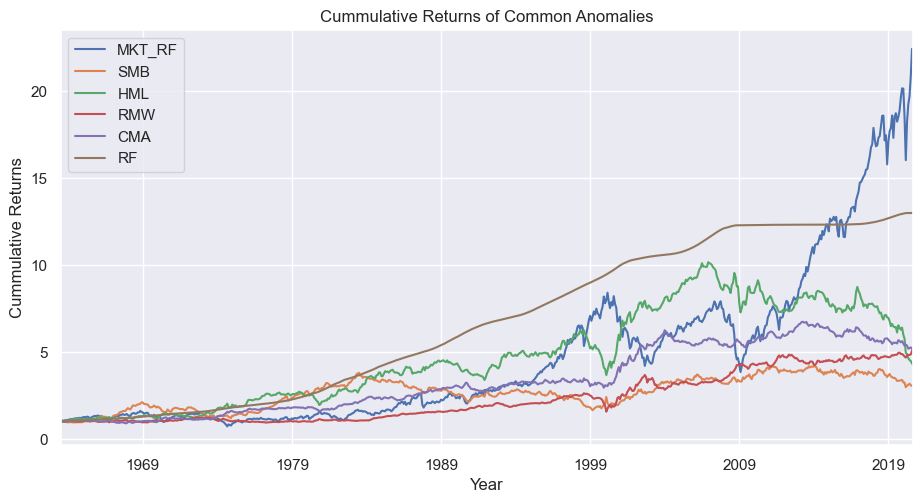

In [6]:
(1 + df_ff_5f_m).cumprod().plot()
plt.title('Cummulative Returns of Common Anomalies')
plt.xlabel('Year')
plt.ylabel('Cummulative Returns')
pass

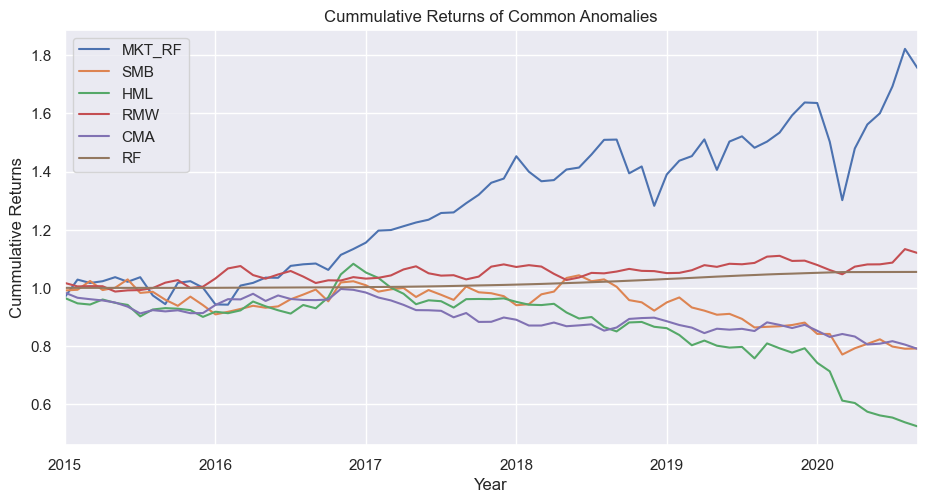

In [7]:
(1 + df_ff_5f_m['2015':]).cumprod().plot()
plt.title('Cummulative Returns of Common Anomalies')
plt.xlabel('Year')
plt.ylabel('Cummulative Returns')
pass

### 3.2.4 Predictive regressions

$$
\mathbf{r} = a + b\mathbf{x} + \mathbf{e}
$$

- $\mathbf{r}$: stacks all returns of all stocks ($\mathcal{F}_t$)
- $\mathbf{x}$: lagged variable(s) ($\mathcal{F}_{t-1}$)
- If the estimate $\hat{b}$ is significant given a specified threshold, then it can be tempting to conclude that $\mathbf{x}$ does a good job at predicting returns.
- Hence, long-short portfolios related to extreme values of $\mathbf{x}$ (mind the sign of $\mathbf{x}$ are expected to generate profits.
- This is unfortunately often false because $\hat{b}$ gives information on the past ability of $\mathbf{x}$ to forecast returns. What happens in the future may be another story.

### 3.2.5 Fama-Macbeth regressions

In [8]:
n_stocks = data_ml.index.get_level_values('stock_id').unique().size

pds_notnull_count = data_ml['R1M_Usd'].notnull().groupby('stock_id').sum()
stock_ids_short = pds_notnull_count[lambda x: x == x.max()].index.to_list()
df_fm_data = data_ml.loc[pd.IndexSlice[stock_ids_short,:], ['R1M_Usd']]

print(f'{round(100*(1-len(stock_ids_short)/n_stocks), 2)}% stocks dropped because of incomplete monthly returns')

34.25% stocks dropped because of incomplete monthly returns


In [9]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = sm.add_constant(data[xvars])
    lm = sm.OLS(Y, X)
    result = lm.fit()
    return result.params

**First pass: estimate betas of individual stocks (time-series regression)**

$$
R_{t}^{ei} = a_i + \beta_i f_t + \epsilon_{t}^i
$$

In [10]:
# R1M_Usd: the 1 month future returns
df_fm_1st_data = (
    df_fm_data.
    merge(df_ff_5f_m, how='left', left_on='month_end', right_index=True).
    sort_index().
    assign(t_R1M_Usd = lambda df: df.groupby(by='stock_id')['R1M_Usd'].shift(1)).
    drop(columns=['R1M_Usd']).dropna()
)
df_fm_1st_data.head(10)

MKT_RF     SMB     HML     RMW     CMA      RF  t_R1M_Usd
stock_id month_end                                                           
1        2000-02    0.0245  0.1805 -0.0905 -0.1848 -0.0051  0.0043     -0.036
         2000-03    0.0520 -0.1486  0.0749  0.1153 -0.0105  0.0047      0.263
         2000-04   -0.0640 -0.0528  0.0768  0.0766  0.0527  0.0046      0.031
         2000-05   -0.0442 -0.0406  0.0491  0.0436  0.0074  0.0050      0.448
         2000-06    0.0464  0.0982 -0.0819 -0.0805 -0.0307  0.0040     -0.097
         2000-07   -0.0251 -0.0101  0.0838  0.0628  0.0299  0.0048     -0.157
         2000-08    0.0703 -0.0096 -0.0146 -0.0317  0.0061  0.0050      0.291
         2000-09   -0.0545  0.0002  0.0730  0.0277  0.0643  0.0051      0.037
         2000-10   -0.0276 -0.0283  0.0569  0.0944  0.0467  0.0056     -0.079
         2000-11   -0.1072 -0.0068  0.1255  0.1338  0.0851  0.0051      0.100

In [11]:
df_fm_betas = (
    df_fm_1st_data.
    groupby('stock_id').
    apply(regress, 't_R1M_Usd', ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA'])
)
df_fm_betas.head(10).round(3)

,const,MKT_RF,SMB,HML,RMW,CMA
stock_id,,,,,,
1,0.008,1.431,0.524,0.634,0.998,-0.397
3,-0.002,0.828,1.101,0.890,0.310,-0.541
4,0.005,0.362,0.298,-0.049,0.587,0.202
7,0.006,0.424,0.681,0.255,0.309,0.116
9,0.004,0.843,0.663,1.075,0.042,0.052
11,-0.001,0.994,0.143,0.481,-0.102,-0.000
12,0.004,0.908,-0.502,-0.156,0.013,0.756
16,-0.000,1.306,-0.055,1.480,0.267,-0.831
17,-0.004,2.042,1.343,0.444,1.540,0.686


**Second pass: estimate factor risk premia across time (cross-sectional regression for each $t$)**

$$
R_{t}^{ei} = \beta_i \lambda_t + \alpha_{it}
$$

In [12]:
df_fm_2nd_data = (
    df_fm_data.
    merge(df_fm_betas.drop(columns=['const']), left_on='stock_id', right_index=True).
    swaplevel().sort_index()
)
df_fm_2nd_data.head(10)

R1M_Usd    MKT_RF       SMB       HML       RMW       CMA
month_end stock_id                                                           
2000-01   1          -0.036  1.430880  0.523742  0.634438  0.997815 -0.396993
          3           0.077  0.828453  1.100639  0.889561  0.310218 -0.541332
          4          -0.016  0.362387  0.298234 -0.048689  0.587353  0.201573
          7          -0.009  0.424303  0.680989  0.255402  0.309364  0.116079
          9           0.032  0.842766  0.662656  1.075435  0.041718  0.051901
          11          0.144  0.993507  0.143105  0.481497 -0.101719 -0.000184
          12         -0.110  0.908352 -0.501651 -0.156212  0.013178  0.755824
          16         -0.191  1.305908 -0.055218  1.480062  0.266909 -0.831451
          17         -0.103  2.041910  1.342608  0.443834  1.539569  0.686023
          18          0.098  0.988507  0.757822  0.253244  0.165173  0.834247

In [13]:
df_imp_premia = (
    df_fm_2nd_data.
    groupby('month_end').
    apply(regress, 'R1M_Usd', ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA'])
)
df_imp_premia.head(10)

,const,MKT_RF,SMB,HML,RMW,CMA
month_end,,,,,,
2000-01,-0.012615,0.042797,0.217570,-0.137015,-0.271884,0.034571
2000-02,0.011511,0.076712,-0.129546,0.044421,0.085677,-0.027268
2000-03,0.006698,-0.011477,-0.014058,0.052387,0.038771,0.042647
2000-04,0.136424,-0.153988,-0.103667,0.157166,0.077962,-0.057640
2000-05,0.050137,-0.009040,0.071651,-0.096466,-0.092811,-0.053810
2000-06,0.026483,-0.029375,-0.017930,0.053083,0.045273,0.017199
2000-07,0.015766,0.070324,-0.004740,-0.037010,-0.054836,0.011708
2000-08,0.061012,-0.085304,-0.027193,0.045190,0.047678,0.037622
2000-09,-0.003131,-0.010933,-0.038613,0.012483,0.067708,0.042711


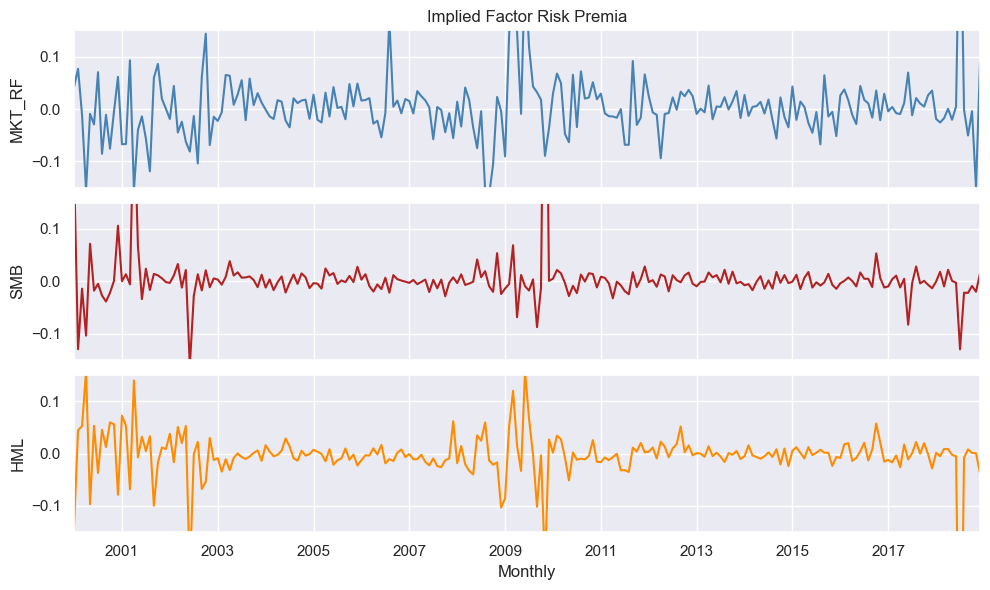

In [14]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
df_imp_premia['MKT_RF'].plot(ax=axes[0], color='steelblue')
axes[0].set_title('Implied Factor Risk Premia')
axes[0].set_ylim([-0.15, 0.15])
axes[0].set_ylabel('MKT_RF')
df_imp_premia['SMB'].plot(ax=axes[1], color='firebrick')
axes[1].set_ylim([-0.15, 0.15])
axes[1].set_ylabel('SMB')
df_imp_premia['HML'].plot(ax=axes[2], color='darkorange')
axes[2].set_ylim([-0.15, 0.15])
axes[2].set_xlabel('Monthly')
axes[2].set_ylabel('HML')
plt.tight_layout()

---